In [1]:
import cdsapi
import xarray

In [2]:
import hashlib
import os

cds_data_dir = "data/cds"


class CDS_Dataset():
    def __init__(self, topic, config):
        self.topic = topic
        self.config = config

    def path(self):
        h = hashlib.new('SHA256')
        h.update(self.topic.encode('utf-8'))
        for k, v in sorted(self.config.items()):
            h.update(f'|{k}:{v}'.encode('utf-8'))
        fingerprint = h.hexdigest()[:16]
        return f"{cds_data_dir}/dataset_{fingerprint}.{self.config["format"]}"
        

    def download_from_cds(self):
        os.makedirs(cds_data_dir, exist_ok=True)
        cdsc = cdsapi.Client()
        cdsc.retrieve(self.topic, self.config, self.path())

    def load(self):
        if not os.path.exists(self.path()):
            self.download_from_cds()

        return self.path()


dataset = CDS_Dataset(
    'satellite-lake-water-temperature', {
        'variable': 'all',
        'format': 'zip',
        'version': '4.5.2',
        'year': '2022',
        'month': [
            '01','02','03',
            '04','05','06',
            '07','08','09',
            '10','11','12',
        ],
        'day': [
            '01','02','03',
            '04','05','06',
            '07','08','09',
            '10','11','12',
            '13','14','15',
            '16','17','18',
            '19','20','21',
            '22','23','24',
            '25','26','27',
            '28','29','30',
            '31',
        ],
        'area': [48.00, 8.54, 47.29, 10.17]
    })

dataset.load()

'data/cds/dataset_39f356db72d96f20.zip'

In [3]:
# Lake Water Surface Temperature
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-lake-water-temperature

default_area = [48.00, 8.54, 47.29, 10.17] # Bodensee

import tempfile
import zipfile

def load_year(area, year):
    topic = 'satellite-lake-water-temperature'
    config = dict(
        variable = 'all',
        format = 'zip',
        version = '4.5.1' if year <= 2020 else '4.5.2',
        year = year,
        month = [ f"{x:02d}" for x in range(1, 13) ],
        day = [ f"{x:02d}" for x in range(1, 32) ],
        area = area,
    )
    return CDS_Dataset(topic, config).load()

def latlontime_array_year(area, year):
    path = load_year(area, year)
    with tempfile.TemporaryDirectory() as tmp:     
        with zipfile.ZipFile(path,"r") as f:
            f.extractall(tmp)
        d = xarray.concat((xarray.open_dataset(e.path) for e in os.scandir(tmp) if e.path.endswith(".nc") ),
                          "time",
                          combine_attrs="drop_conflicts")
    return d
    
def latlontime_array(area, years=range(1995, 2024)):
    d = xarray.concat(( latlontime_array_year(area, y) for y in years ),
                      "time",
                      combine_attrs="drop_conflicts")
    return d 

d = latlontime_array(default_area, years=[2021, 2022, 2023])
d.to_netcdf('data/abc.nc')
d

<xarray.Dataset> Size: 18MB
Dimensions:                         (time: 1095, lat: 14, lon: 32)
Coordinates:
  * lat                             (lat) float32 56B 47.33 47.38 ... 47.97
  * lon                             (lon) float32 128B 8.575 8.625 ... 10.12
  * time                            (time) datetime64[ns] 9kB 2021-05-30T12:0...
Data variables:
    lake_surface_water_temperature  (time, lat, lon) float32 2MB nan nan ... nan
    lswt_uncertainty                (time, lat, lon) float32 2MB nan nan ... nan
    lswt_quality_level              (time, lat, lon) float32 2MB nan nan ... nan
    lswt_obs_instr                  (time, lat, lon) float32 2MB nan nan ... nan
    lswt_flag_bias_correction       (time, lat, lon) float32 2MB nan nan ... nan
    lakeid_CCI                      (time, lat, lon) float64 4MB nan nan ... nan
    lakeid_GloboLakes               (time, lat, lon) float64 4MB nan nan ... nan
Attributes: (12/45)
    title:                           UK Earth Observation Climate Information...
    institution:                     EOCIS, University of Reading
    summary:                         L3S product from the ESA CCI project: LS...
    citation:                        Carrea, L., Crétaux, J.-F., Liu, X., Wu,...
    licence:                         Creative Commons Attribution 4.0 Interna...
    reference:                       https://cds.climate.copernicus.eu
    ...                              ...
    westernmost_longitude:           -180.0
    processing_level:                L3S
    cdm_data_type:                   grid
    platform:                        Sentinel3A Sentinel3B
    sensor:                          SLSTRA-SLSTRB
    source_file_path:                /gws/nopw/j04/nceo_uor/users/lcarrea01/O...

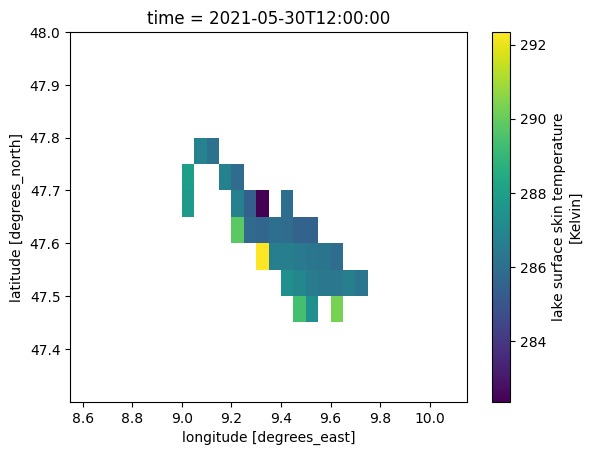

In [4]:
xarray.load_dataset('data/abc.nc').sel(time='2021-05-30T12:00')['lake_surface_water_temperature'].plot()